# Inteligencia Articificial Avanzada
# Segunda entrega





Usamos CNN en PyTorch para comparar contra ResNet-18

### Dataset

In [1]:
import torch
import torchvision
from torchvision import transforms
from google.colab import drive
import os
import numpy as np

# Montar Google Drive
drive.mount('/content/drive')

# Ruta del archivo CIFAR-10 en Google Drive
cifar_path = '/content/drive/My Drive/cifar_dataset.pth'

# Verificar si el archivo ya existe en Google Drive
if not os.path.exists(cifar_path):
    # Descargar el conjunto de datos CIFAR-10 si el archivo no existe
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Guardar el conjunto de datos directamente en Google Drive
    torch.save(cifar_dataset, cifar_path)
    print("El archivo cifar_dataset.pth ha sido descargado y guardado en Google Drive.")
else:
    # Cargar el conjunto de datos desde el archivo existente en Google Drive
    cifar_dataset = torch.load(cifar_path)
    print("El archivo cifar_dataset.pth ya existe en Google Drive y ha sido cargado.")

# Desmontar Google Drive
drive.flush_and_unmount()
print("Google Drive ha sido desmontado.")

# Imprimir la cantidad total de imágenes en el conjunto de datos CIFAR-10
print(f"Número total de imágenes en CIFAR-10: {len(cifar_dataset)}")

Mounted at /content/drive
El archivo cifar_dataset.pth ya existe en Google Drive y ha sido cargado.
Google Drive ha sido desmontado.
Número total de imágenes en CIFAR-10: 50000


Número de datos de entrenamiento: 20250
Número de datos de validación: 1125
Número de datos de testeo: 3750



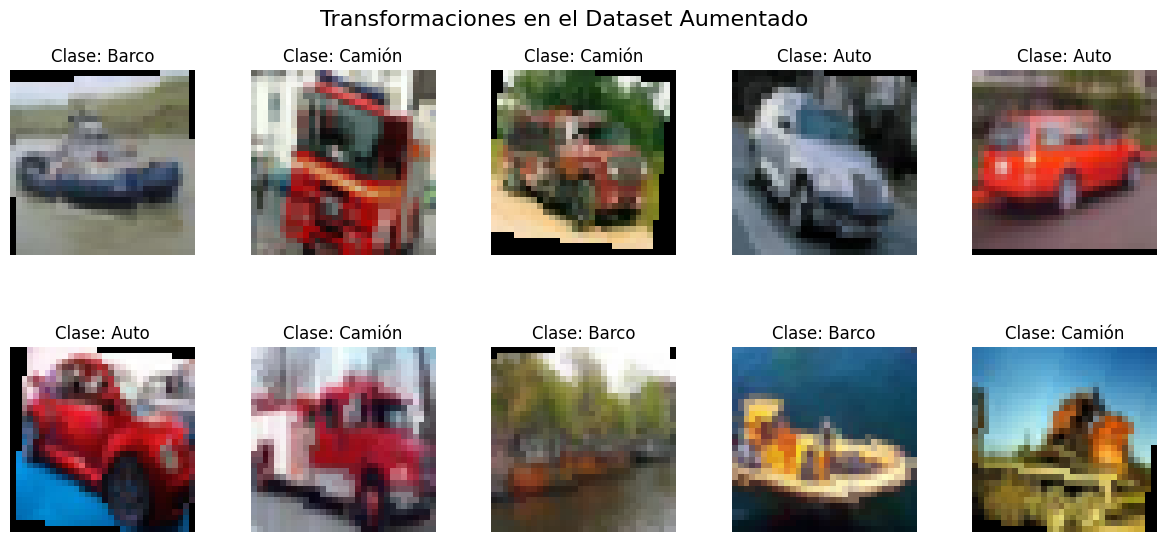

In [2]:
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset, DataLoader

# Define las clases que quieres mantener (auto, barco, camión)
classes_to_keep = [1, 8, 9]

# Filtra el conjunto de datos para quedarte solo con las clases deseadas
filtered_data = [(image, label) for image, label in cifar_dataset if label in classes_to_keep]

# Mapea los índices de las clases a identificadores numéricos (0, 1, 2)
class_to_idx = {1: 0, 8: 1, 9: 2}
class_names = ["Auto", "Barco", "Camión"]

filtered_data_numeric = [(image, class_to_idx[label]) for image, label in filtered_data]

# Separar el dataset en 75% entrenamiento y 25% testeo
train_data, test_data = train_test_split(filtered_data_numeric, test_size=0.25, random_state=42)

# Separar la parte de entrenamiento en 90% entrenamiento y 10% validación
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Definir transformaciones de aumento de datos para el conjunto de entrenamiento
transformations = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=1)
])

# Aplicar las transformaciones de aumento de datos al conjunto de entrenamiento original
augmented_train_data = [(transformations(image), label) for image, label in train_data]

# Combinar el conjunto de entrenamiento original con el conjunto de entrenamiento aumentado
combined_train_dataset = ConcatDataset([train_data, augmented_train_data])
train_data = combined_train_dataset  # Se lo vuelvo a asignar

# Crear dataloaders para entrenamiento, validación y testeo
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

# Verificar la cantidad de datos en cada conjunto
print(f"Número de datos de entrenamiento: {len(train_data)}")
print(f"Número de datos de validación: {len(val_data)}")
print(f"Número de datos de testeo: {len(test_data)}")
print()

# Plotear las primeras 10 imágenes del conjunto de datos aumentado
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5)
plt.suptitle('Transformaciones en el Dataset Aumentado', fontsize=16)

for i in range(10):
    ax = axs[i // 5, i % 5]
    image, label = augmented_train_data[i]
    image = torchvision.utils.make_grid(image)
    np_image = image.numpy()

    # Obtener el nombre de la clase correspondiente al número de la clase
    class_name = class_names[label]

    ax.imshow(np.transpose(np_image, (1, 2, 0)))
    # Mostrar el nombre de la clase en lugar del número de clase
    ax.set_title(f'Clase: {class_name}')
    ax.axis('off')

plt.show()

### CNN (En la primera entrega usamos Keras)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np

# Verificar si hay una GPU disponible y, en caso contrario, usar la CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir un modelo de CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 64 channels * 8 * 8 image size after max pooling
        self.fc2 = nn.Linear(512, len(classes_to_keep))

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Inicializar el modelo de CNN en el dispositivo adecuado
net = CNN().to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Métricas de entrenamiento y validación
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
val_f1_score_history = []  # Historial del F1 Score en el conjunto de validación
val_recall_score_history = []  # Historial del Recall en el conjunto de validación

# Función para calcular las predicciones en el conjunto de validación
def get_predictions(net, dataloader):
    all_labels = []
    all_preds = []
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Mover los datos al dispositivo
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())  # en CPU
            all_preds.extend(predicted.cpu().numpy())  # en CPU
    return np.array(all_labels), np.array(all_preds)

# Función para calcular el F1 Score y el Recall en el conjunto de validación
def calculate_metrics(net, dataloader):
    true_labels, predictions = get_predictions(net, dataloader)
    f1 = f1_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    return f1, recall

# Entrenamiento del modelo
for epoch in range(20):  # Épocas
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):  # Utiliza el dataloader de entrenamiento
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Mover los datos al dispositivo

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    train_loss_history.append(running_loss / len(train_loader))
    train_accuracy_history.append(accuracy)

    # Validación
    val_loss = 0.0
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in val_loader:  # Utiliza el dataloader de validación
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Mover los datos al dispositivo
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        val_loss_history.append(val_loss / len(val_loader))
        val_accuracy_history.append(accuracy)

        # Calcular y almacenar el F1 Score y Recall en el conjunto de validación
        val_f1, val_recall = calculate_metrics(net, val_loader)
        val_f1_score_history.append(val_f1)
        val_recall_score_history.append(val_recall)

        print(f'Epoch {epoch + 1}, Train Loss: {running_loss / len(train_loader):.2f}, Train Accuracy: {train_accuracy_history[-1]:.2f} | Val Loss: {val_loss_history[-1]:.2f}, Val Accuracy: {val_accuracy_history[-1]:.2f}, Val F1 Score: {val_f1:.2f}, Val Recall: {val_recall:.2f}')

# Imprimir las líneas de accuracy, loss, F1 Score y Recall al final de cada época
print()
print('Finished Training:')
print(f'Training Accuracy: {train_accuracy_history[-1]:.2f}, Training Loss: {train_loss_history[-1]:.2f}')
print(f'Validation Accuracy: {val_accuracy_history[-1]:.2f}, Validation Loss: {val_loss_history[-1]:.2f}')
print(f'Validation F1 Score: {val_f1_score_history[-1]:.2f}, Validation Recall: {val_recall_score_history[-1]:.2f}')

# Obtener las predicciones en el conjunto de entrenamiento, validación y testeo
val_true_labels, val_predictions = get_predictions(net, val_loader)
train_true_labels, train_predictions = get_predictions(net, train_loader)
test_true_labels, test_predictions = get_predictions(net, test_loader)

# Calcular las matrices de confusión para el conjunto de entrenamiento, validación y testeo
train_confusion_matrix = confusion_matrix(train_true_labels, train_predictions)
val_confusion_matrix = confusion_matrix(val_true_labels, val_predictions)
test_confusion_matrix = confusion_matrix(test_true_labels, test_predictions)

# Imprimir las matrices de confusión en forma de lista
print()
print("\nMatriz de Confusión - Entrenamiento:")
print(train_confusion_matrix)
print("\nMatriz de Confusión - Validación:")
print(val_confusion_matrix)
print("\nMatriz de Confusión - Testeo:")
print(test_confusion_matrix)
print()
print(net)

Epoch 1, Train Loss: 1.02, Train Accuracy: 0.51 | Val Loss: 0.88, Val Accuracy: 0.60, Val F1 Score: 0.59, Val Recall: 0.60
Epoch 2, Train Loss: 0.82, Train Accuracy: 0.62 | Val Loss: 0.74, Val Accuracy: 0.66, Val F1 Score: 0.66, Val Recall: 0.66
Epoch 3, Train Loss: 0.74, Train Accuracy: 0.67 | Val Loss: 0.67, Val Accuracy: 0.70, Val F1 Score: 0.70, Val Recall: 0.70
Epoch 4, Train Loss: 0.68, Train Accuracy: 0.70 | Val Loss: 0.63, Val Accuracy: 0.72, Val F1 Score: 0.73, Val Recall: 0.72
Epoch 5, Train Loss: 0.63, Train Accuracy: 0.73 | Val Loss: 0.58, Val Accuracy: 0.75, Val F1 Score: 0.75, Val Recall: 0.75
Epoch 6, Train Loss: 0.59, Train Accuracy: 0.75 | Val Loss: 0.55, Val Accuracy: 0.77, Val F1 Score: 0.77, Val Recall: 0.77
Epoch 7, Train Loss: 0.56, Train Accuracy: 0.77 | Val Loss: 0.54, Val Accuracy: 0.79, Val F1 Score: 0.79, Val Recall: 0.79
Epoch 8, Train Loss: 0.53, Train Accuracy: 0.78 | Val Loss: 0.50, Val Accuracy: 0.80, Val F1 Score: 0.80, Val Recall: 0.80
Epoch 9, Train L

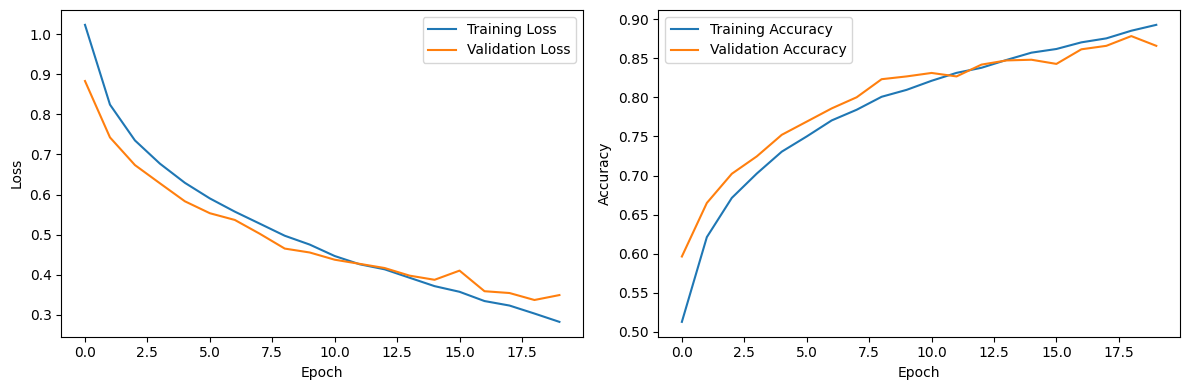

In [4]:
import matplotlib.pyplot as plt

# Graficar curvas de entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
from tabulate import tabulate
import numpy as np
import warnings

# Etiquetas reales de entrenamiento, prueba y validación
y_train = [label for _, label in train_data]
y_test = [label for _, label in test_data]
y_validation = [label for _, label in val_data]

# Lista de nombres de clases
class_names = ["auto", "barco", "camion"]

# Crear un DataFrame para almacenar las estadísticas por clase y conjunto
class_stats = pd.DataFrame(index=class_names, columns=['Cantidad en Entrenamiento', 'Cantidad en Validación', 'Cantidad en Testeo', 'Total'])

# Calcular la cantidad en el conjunto de entrenamiento, validación y prueba por clase
for i, class_name in enumerate(class_names):
    train_mask = np.array(y_train) == i
    validation_mask = np.array(y_validation) == i
    test_mask = np.array(y_test) == i
    class_stats.at[class_name, 'Cantidad en Entrenamiento'] = sum(train_mask)
    class_stats.at[class_name, 'Cantidad en Validación'] = sum(validation_mask)
    class_stats.at[class_name, 'Cantidad en Testeo'] = sum(test_mask)
    class_stats.at[class_name, 'Total'] = sum(train_mask) + sum(validation_mask) + sum(test_mask)

# Convertir los valores a enteros y eliminar los corchetes [ ]
class_stats = class_stats.astype({'Cantidad en Entrenamiento': int, 'Cantidad en Validación': int, 'Cantidad en Testeo': int})

# Calcular los totales en la primera tabla
total_entrenamiento = class_stats['Cantidad en Entrenamiento'].sum()
total_validacion = class_stats['Cantidad en Validación'].sum()
total_testeo = class_stats['Cantidad en Testeo'].sum()

# Agregar los totales en la primera tabla
class_stats.loc['Total'] = [total_entrenamiento, total_validacion, total_testeo, total_entrenamiento + total_validacion + total_testeo]

# Desactivar las advertencias específicas que se están generando
warnings.filterwarnings("ignore", message="elementwise comparison failed; returning scalar instead")

# Función para calcular el porcentaje
def calculate_percentage(correct, incorrect):
    total = correct + incorrect
    if total == 0:
        return 0.0
    return (correct / total) * 100.0

# Calcular la cantidad de predicciones correctas e incorrectas por clase en los tres conjuntos
correct_train_per_class = [train_confusion_matrix[i, i] for i in range(len(class_names))]
incorrect_train_per_class = [sum(train_confusion_matrix[i, :]) - train_confusion_matrix[i, i] for i in range(len(class_names))]

correct_valid_per_class = [val_confusion_matrix[i, i] for i in range(len(class_names))]
incorrect_valid_per_class = [sum(val_confusion_matrix[i, :]) - val_confusion_matrix[i, i] for i in range(len(class_names))]

correct_testeo_per_class = [test_confusion_matrix[i, i] for i in range(len(class_names))]
incorrect_testeo_per_class = [sum(test_confusion_matrix[i, :]) - test_confusion_matrix[i, i] for i in range(len(class_names))]

# Crear listas de listas para las tablas de los tres conjuntos
train_table_data = []
valid_table_data = []
testeo_table_data = []

for class_name, correct_count, incorrect_count in zip(class_names, correct_train_per_class, incorrect_train_per_class):
    train_percentage = calculate_percentage(correct_count, incorrect_count)
    train_table_data.append([class_name, correct_count, incorrect_count, f"{train_percentage:.2f}%"])

for class_name, correct_count, incorrect_count in zip(class_names, correct_valid_per_class, incorrect_valid_per_class):
    valid_percentage = calculate_percentage(correct_count, incorrect_count)
    valid_table_data.append([class_name, correct_count, incorrect_count, f"{valid_percentage:.2f}%"])

for class_name, correct_count, incorrect_count in zip(class_names, correct_testeo_per_class, incorrect_testeo_per_class):
    testeo_percentage = calculate_percentage(correct_count, incorrect_count)
    testeo_table_data.append([class_name, correct_count, incorrect_count, f"{testeo_percentage:.2f}%"])

# Agregar una fila con la suma de cada columna en las tablas de predicciones
train_table_data.append(['Total', sum(correct_train_per_class), sum(incorrect_train_per_class), ''])
valid_table_data.append(['Total', sum(correct_valid_per_class), sum(incorrect_valid_per_class), ''])
testeo_table_data.append(['Total', sum(correct_testeo_per_class), sum(incorrect_testeo_per_class), ''])

# Calcular los porcentajes de aciertos en los totales
total_aciertos_train = calculate_percentage(sum(correct_train_per_class), sum(incorrect_train_per_class))
total_aciertos_valid = calculate_percentage(sum(correct_valid_per_class), sum(incorrect_valid_per_class))
total_aciertos_testeo = calculate_percentage(sum(correct_testeo_per_class), sum(incorrect_testeo_per_class))

# Agregar los porcentajes de aciertos en la fila de Totales de las tablas de predicciones
train_table_data[-1][-1] = f"{total_aciertos_train:.2f}%"
valid_table_data[-1][-1] = f"{total_aciertos_valid:.2f}%"
testeo_table_data[-1][-1] = f"{total_aciertos_testeo:.2f}%"

# Imprimir las tablas formateadas para los tres conjuntos
table_headers = ["Clase", "Predicciones Correctas", "Predicciones Incorrectas", "Porcentaje de Aciertos"]

def print_table(title, data):
    print(title)
    table = tabulate(data, headers=table_headers, tablefmt='pretty', numalign='center', stralign='center', colalign=("center", "center", "center", "center"))
    print(table)

print_table("Tabla de Predicciones (Entrenamiento):", train_table_data)
print_table("Tabla de Predicciones (Validación):", valid_table_data)
print_table("Tabla de Predicciones (Testeo):", testeo_table_data)

Tabla de Predicciones (Entrenamiento):
+--------+------------------------+--------------------------+------------------------+
| Clase  | Predicciones Correctas | Predicciones Incorrectas | Porcentaje de Aciertos |
+--------+------------------------+--------------------------+------------------------+
|  auto  |          6180          |           440            |         93.35%         |
| barco  |          6242          |           634            |         90.78%         |
| camion |          5798          |           956            |         85.85%         |
| Total  |         18220          |           2030           |         89.98%         |
+--------+------------------------+--------------------------+------------------------+
Tabla de Predicciones (Validación):
+--------+------------------------+--------------------------+------------------------+
| Clase  | Predicciones Correctas | Predicciones Incorrectas | Porcentaje de Aciertos |
+--------+------------------------+----------

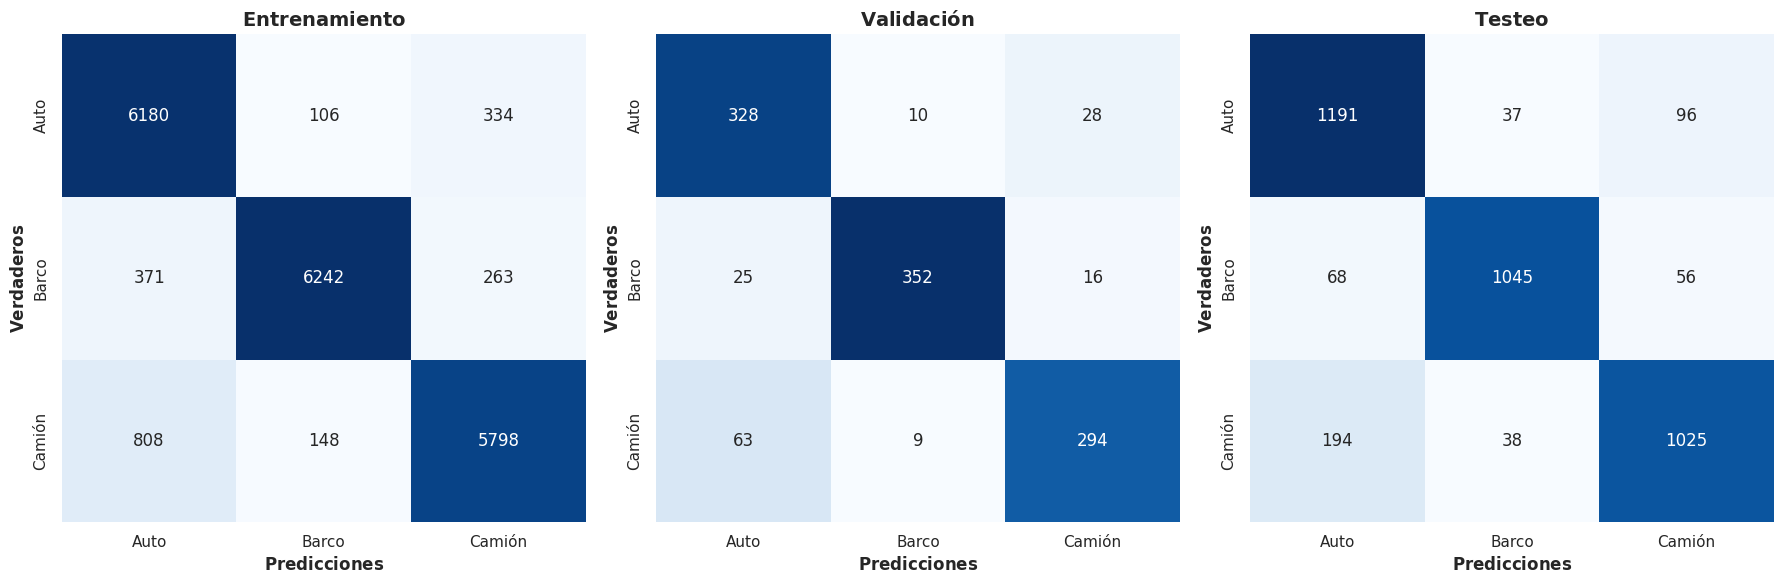

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nombres de las clases
class_names = ['Auto', 'Barco', 'Camión']

# Establecer un estilo personalizado
sns.set_theme(style="whitegrid", palette="pastel")

# Crear un gráfico con 1 fila y 3 columnas para mostrar las matrices de confusión
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Graficar las matrices de confusión en orientación horizontal sin la barra de colores
sns.heatmap(train_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axs[0])
axs[0].set_title(r'$\bf{Entrenamiento}$', fontsize=14)
axs[0].set_xlabel(r'$\bf{Predicciones}$', fontsize=12)
axs[0].set_ylabel(r'$\bf{Verdaderos}$', fontsize=12)

sns.heatmap(val_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axs[1])
axs[1].set_title(r'$\bf{Validación}$', fontsize=14)
axs[1].set_xlabel(r'$\bf{Predicciones}$', fontsize=12)
axs[1].set_ylabel(r'$\bf{Verdaderos}$', fontsize=12)

sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axs[2])
axs[2].set_title(r'$\bf{Testeo}$', fontsize=14)
axs[2].set_xlabel(r'$\bf{Predicciones}$', fontsize=12)
axs[2].set_ylabel(r'$\bf{Verdaderos}$', fontsize=12)

# Ajustar el diseño para evitar solapamiento de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [7]:
from prettytable import PrettyTable

# Definir un diccionario que mapea los índices a los nombres de las clases
class_to_idx = {"auto": 0, "barco": 1, "camión": 2}
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Encontrar las primeras predicciones incorrectas en el conjunto de prueba
incorrect_predictions = []
for i in range(len(test_true_labels)):
    if test_true_labels[i] != test_predictions[i]:
        incorrect_predictions.append(i)
    if len(incorrect_predictions) == 50:
        break

# Crear una tabla para mostrar los resultados incorrectos
table = PrettyTable(["Índice", "True Value", "True Class", "Predicted", "Predicted Class"])

# Llenar la tabla con las primeras 10 predicciones incorrectas
for i in incorrect_predictions:
    table.add_row([i, test_true_labels[i], idx_to_class[test_true_labels[i]],
                   test_predictions[i], idx_to_class[test_predictions[i]]])

# Imprimir la tabla de las primeras predicciones incorrectas para el conjunto de prueba
print("Predicciones Incorrectas para el Conjunto de Prueba:")
print(table)

Predicciones Incorrectas para el Conjunto de Prueba:
+--------+------------+------------+-----------+-----------------+
| Índice | True Value | True Class | Predicted | Predicted Class |
+--------+------------+------------+-----------+-----------------+
|   23   |     0      |    auto    |     2     |      camión     |
|   40   |     1      |   barco    |     0     |       auto      |
|   49   |     0      |    auto    |     2     |      camión     |
|   54   |     0      |    auto    |     2     |      camión     |
|   55   |     0      |    auto    |     2     |      camión     |
|   82   |     2      |   camión   |     0     |       auto      |
|   83   |     2      |   camión   |     0     |       auto      |
|   91   |     0      |    auto    |     2     |      camión     |
|  109   |     0      |    auto    |     1     |      barco      |
|  117   |     2      |   camión   |     0     |       auto      |
|  124   |     0      |    auto    |     2     |      camión     |
|  130   

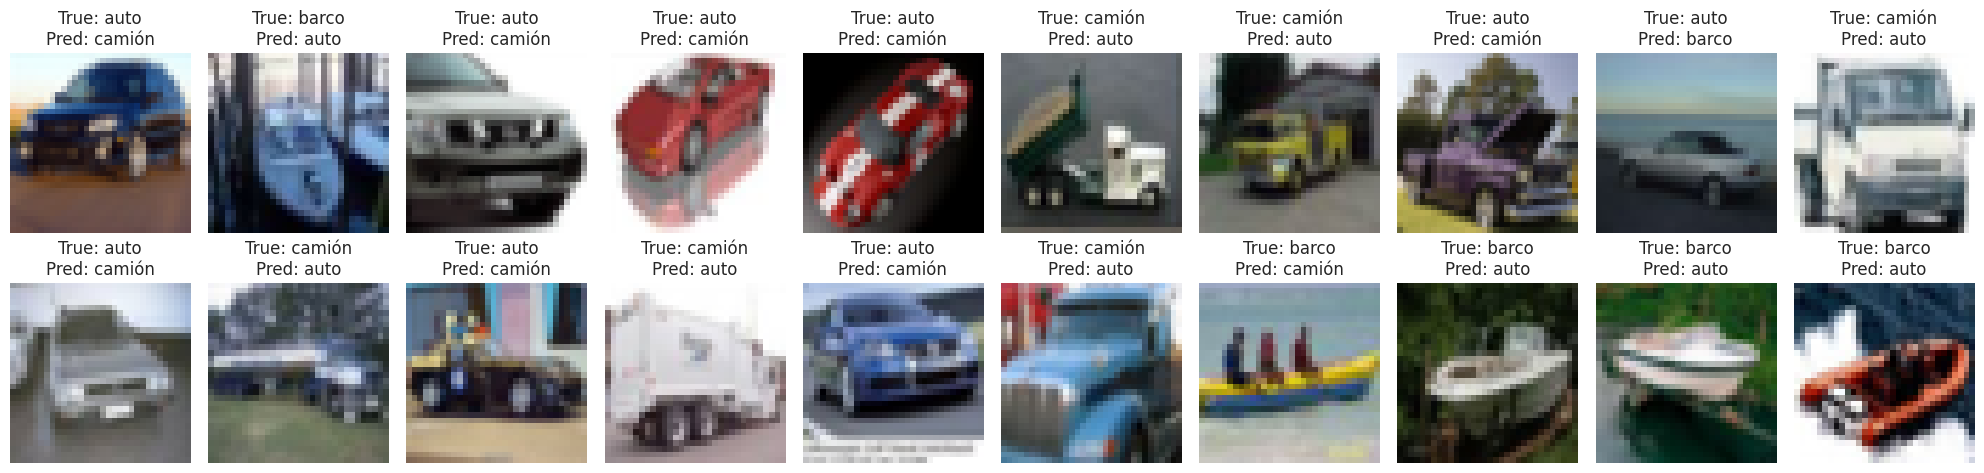

In [8]:
# Obtener las primeras 20 predicciones del conjunto definido arriba
incorrect_predictions = incorrect_predictions[:20]

# Crear una figura con dos filas y diez columnas
fig, axs = plt.subplots(2, 10, figsize=(20, 5))

# Iterar sobre las primeras 20 predicciones incorrectas
for i, ax in enumerate(axs.flat):
    # Obtener el índice de la predicción incorrecta
    incorrect_idx = incorrect_predictions[i]

    # Obtener la imagen, la clase real y la predicción
    img = test_data[incorrect_idx][0].permute(1, 2, 0).numpy()
    true_class = idx_to_class[test_true_labels[incorrect_idx]]
    predicted_class = idx_to_class[test_predictions[incorrect_idx]]

    # Mostrar la imagen
    ax.imshow(img)
    ax.set_title(f'True: {true_class}\nPred: {predicted_class}')
    ax.axis('off')

# Mostrar el resultado
plt.tight_layout()
plt.show()

### ResNet-18

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np

# Definir clases y dataloaders
classes_to_keep = [1, 8, 9]
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

# Definir el modelo ResNet
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Inicializar el modelo y los parámetros de entrenamiento
num_classes = len(classes_to_keep)
net = ResNetModel(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Función para calcular las predicciones en el conjunto de validación
def get_predictions(net, dataloader):
    all_labels = []
    all_preds = []
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Mover los datos al dispositivo
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())  # en CPU
            all_preds.extend(predicted.cpu().numpy())  # en CPU
    return np.array(all_labels), np.array(all_preds)

# Métricas de entrenamiento y validación
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
val_f1_score_history = []  # Historial del F1 Score en el conjunto de validación
val_recall_score_history = []  # Historial del Recall en el conjunto de validación

# Entrenamiento del modelo
num_epochs = 20

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    train_loss_history.append(running_loss / len(train_loader))
    train_accuracy_history.append(accuracy)

    # Validación
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predictions = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Agregar las etiquetas verdaderas y las predicciones para calcular el F1 Score y Recall
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    val_loss_history.append(val_loss / len(val_loader))
    val_accuracy_history.append(accuracy)

    # Calcular el F1 Score y Recall y almacenarlos en el historial
    val_f1 = f1_score(true_labels, predictions, average='weighted')
    val_recall = recall_score(true_labels, predictions, average='weighted')
    val_f1_score_history.append(val_f1)
    val_recall_score_history.append(val_recall)

    print(f'Epoch {epoch + 1}, Train Loss: {running_loss / len(train_loader):.2f}, Train Accuracy: {train_accuracy_history[-1]:.2f} | Val Loss: {val_loss_history[-1]:.2f}, Val Accuracy: {val_accuracy_history[-1]:.2f}, Val F1 Score: {val_f1:.2f}, Val Recall: {val_recall:.2f}')

# Imprimir las líneas de accuracy, loss, F1 Score y Recall al final de cada época
print()
print('Finished Training:')
print(f'Training Accuracy: {train_accuracy_history[-1]:.2f}, Training Loss: {train_loss_history[-1]:.2f}')
print(f'Validation Accuracy: {val_accuracy_history[-1]:.2f}, Validation Loss: {val_loss_history[-1]:.2f}')
print(f'Validation F1 Score: {val_f1_score_history[-1]:.2f}, Validation Recall: {val_recall_score_history[-1]:.2f}')

# Obtener las predicciones en el conjunto de entrenamiento, validación y testeo
val_true_labels, val_predictions = get_predictions(net, val_loader)
train_true_labels, train_predictions = get_predictions(net, train_loader)
test_true_labels, test_predictions = get_predictions(net, test_loader)

# Calcular las matrices de confusión para el conjunto de entrenamiento, validación y testeo
train_confusion_matrix = confusion_matrix(train_true_labels, train_predictions)
val_confusion_matrix = confusion_matrix(val_true_labels, val_predictions)
test_confusion_matrix = confusion_matrix(test_true_labels, test_predictions)

# Imprimir las matrices de confusión en forma de lista
print()
print("\nMatriz de Confusión - Entrenamiento:")
print(train_confusion_matrix)
print("\nMatriz de Confusión - Validación:")
print(val_confusion_matrix)
print("\nMatriz de Confusión - Testeo:")
print(test_confusion_matrix)
print()
print(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.46, Train Accuracy: 0.82 | Val Loss: 0.67, Val Accuracy: 0.75, Val F1 Score: 0.72, Val Recall: 0.75
Epoch 2, Train Loss: 0.29, Train Accuracy: 0.89 | Val Loss: 0.24, Val Accuracy: 0.92, Val F1 Score: 0.92, Val Recall: 0.92
Epoch 3, Train Loss: 0.23, Train Accuracy: 0.92 | Val Loss: 0.25, Val Accuracy: 0.91, Val F1 Score: 0.91, Val Recall: 0.91
Epoch 4, Train Loss: 0.19, Train Accuracy: 0.93 | Val Loss: 0.22, Val Accuracy: 0.92, Val F1 Score: 0.92, Val Recall: 0.92
Epoch 5, Train Loss: 0.15, Train Accuracy: 0.95 | Val Loss: 0.31, Val Accuracy: 0.90, Val F1 Score: 0.90, Val Recall: 0.90
Epoch 6, Train Loss: 0.13, Train Accuracy: 0.96 | Val Loss: 0.19, Val Accuracy: 0.93, Val F1 Score: 0.93, Val Recall: 0.93
Epoch 7, Train Loss: 0.11, Train Accuracy: 0.96 | Val Loss: 0.22, Val Accuracy: 0.91, Val F1 Score: 0.91, Val Recall: 0.91
Epoch 8, Train Loss: 0.08, Train Accuracy: 0.97 | Val Loss: 0.23, Val Accuracy: 0.91, Val F1 Score: 0.91, Val Recall: 0.91
Epoch 9, Train L

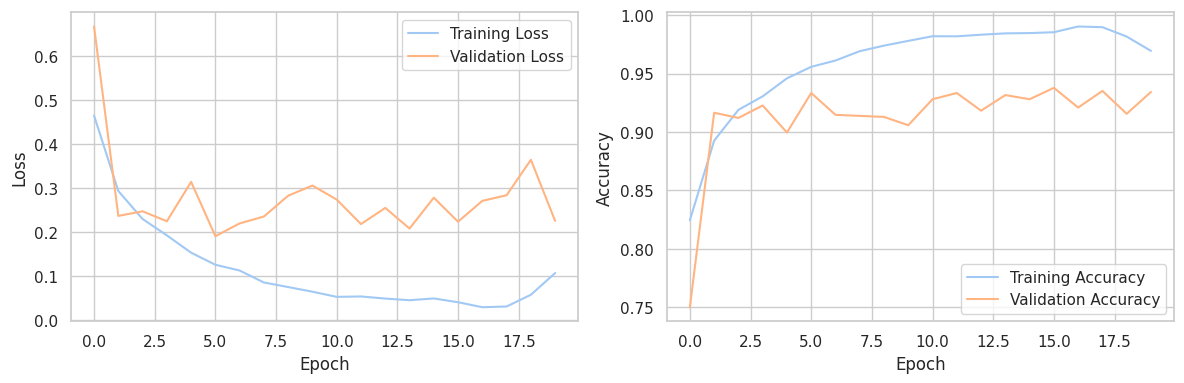

In [10]:
import matplotlib.pyplot as plt

# Graficar curvas de entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
from tabulate import tabulate
import numpy as np
import warnings

# Etiquetas reales de entrenamiento, prueba y validación
y_train = [label for _, label in train_data]
y_test = [label for _, label in test_data]
y_validation = [label for _, label in val_data]

# Lista de nombres de clases
class_names = ["auto", "barco", "camion"]

# Crear un DataFrame para almacenar las estadísticas por clase y conjunto
class_stats = pd.DataFrame(index=class_names, columns=['Cantidad en Entrenamiento', 'Cantidad en Validación', 'Cantidad en Testeo', 'Total'])

# Calcular la cantidad en el conjunto de entrenamiento, validación y prueba por clase
for i, class_name in enumerate(class_names):
    train_mask = np.array(y_train) == i
    validation_mask = np.array(y_validation) == i
    test_mask = np.array(y_test) == i
    class_stats.at[class_name, 'Cantidad en Entrenamiento'] = sum(train_mask)
    class_stats.at[class_name, 'Cantidad en Validación'] = sum(validation_mask)
    class_stats.at[class_name, 'Cantidad en Testeo'] = sum(test_mask)
    class_stats.at[class_name, 'Total'] = sum(train_mask) + sum(validation_mask) + sum(test_mask)

# Convertir los valores a enteros y eliminar los corchetes [ ]
class_stats = class_stats.astype({'Cantidad en Entrenamiento': int, 'Cantidad en Validación': int, 'Cantidad en Testeo': int})

# Calcular los totales en la primera tabla
total_entrenamiento = class_stats['Cantidad en Entrenamiento'].sum()
total_validacion = class_stats['Cantidad en Validación'].sum()
total_testeo = class_stats['Cantidad en Testeo'].sum()

# Agregar los totales en la primera tabla
class_stats.loc['Total'] = [total_entrenamiento, total_validacion, total_testeo, total_entrenamiento + total_validacion + total_testeo]

# Desactivar las advertencias específicas que se están generando
warnings.filterwarnings("ignore", message="elementwise comparison failed; returning scalar instead")

# Función para calcular el porcentaje
def calculate_percentage(correct, incorrect):
    total = correct + incorrect
    if total == 0:
        return 0.0
    return (correct / total) * 100.0

# Calcular la cantidad de predicciones correctas e incorrectas por clase en los tres conjuntos
correct_train_per_class = [train_confusion_matrix[i, i] for i in range(len(class_names))]
incorrect_train_per_class = [sum(train_confusion_matrix[i, :]) - train_confusion_matrix[i, i] for i in range(len(class_names))]

correct_valid_per_class = [val_confusion_matrix[i, i] for i in range(len(class_names))]
incorrect_valid_per_class = [sum(val_confusion_matrix[i, :]) - val_confusion_matrix[i, i] for i in range(len(class_names))]

correct_testeo_per_class = [test_confusion_matrix[i, i] for i in range(len(class_names))]
incorrect_testeo_per_class = [sum(test_confusion_matrix[i, :]) - test_confusion_matrix[i, i] for i in range(len(class_names))]

# Crear listas de listas para las tablas de los tres conjuntos
train_table_data = []
valid_table_data = []
testeo_table_data = []

for class_name, correct_count, incorrect_count in zip(class_names, correct_train_per_class, incorrect_train_per_class):
    train_percentage = calculate_percentage(correct_count, incorrect_count)
    train_table_data.append([class_name, correct_count, incorrect_count, f"{train_percentage:.2f}%"])

for class_name, correct_count, incorrect_count in zip(class_names, correct_valid_per_class, incorrect_valid_per_class):
    valid_percentage = calculate_percentage(correct_count, incorrect_count)
    valid_table_data.append([class_name, correct_count, incorrect_count, f"{valid_percentage:.2f}%"])

for class_name, correct_count, incorrect_count in zip(class_names, correct_testeo_per_class, incorrect_testeo_per_class):
    testeo_percentage = calculate_percentage(correct_count, incorrect_count)
    testeo_table_data.append([class_name, correct_count, incorrect_count, f"{testeo_percentage:.2f}%"])

# Agregar una fila con la suma de cada columna en las tablas de predicciones
train_table_data.append(['Total', sum(correct_train_per_class), sum(incorrect_train_per_class), ''])
valid_table_data.append(['Total', sum(correct_valid_per_class), sum(incorrect_valid_per_class), ''])
testeo_table_data.append(['Total', sum(correct_testeo_per_class), sum(incorrect_testeo_per_class), ''])

# Calcular los porcentajes de aciertos en los totales
total_aciertos_train = calculate_percentage(sum(correct_train_per_class), sum(incorrect_train_per_class))
total_aciertos_valid = calculate_percentage(sum(correct_valid_per_class), sum(incorrect_valid_per_class))
total_aciertos_testeo = calculate_percentage(sum(correct_testeo_per_class), sum(incorrect_testeo_per_class))

# Agregar los porcentajes de aciertos en la fila de Totales de las tablas de predicciones
train_table_data[-1][-1] = f"{total_aciertos_train:.2f}%"
valid_table_data[-1][-1] = f"{total_aciertos_valid:.2f}%"
testeo_table_data[-1][-1] = f"{total_aciertos_testeo:.2f}%"

# Imprimir las tablas formateadas para los tres conjuntos
table_headers = ["Clase", "Predicciones Correctas", "Predicciones Incorrectas", "Porcentaje de Aciertos"]

def print_table(title, data):
    print(title)
    table = tabulate(data, headers=table_headers, tablefmt='pretty', numalign='center', stralign='center', colalign=("center", "center", "center", "center"))
    print(table)

print_table("Tabla de Predicciones (Entrenamiento):", train_table_data)
print_table("Tabla de Predicciones (Validación):", valid_table_data)
print_table("Tabla de Predicciones (Testeo):", testeo_table_data)

Tabla de Predicciones (Entrenamiento):
+--------+------------------------+--------------------------+------------------------+
| Clase  | Predicciones Correctas | Predicciones Incorrectas | Porcentaje de Aciertos |
+--------+------------------------+--------------------------+------------------------+
|  auto  |          6575          |            45            |         99.32%         |
| barco  |          6875          |            1             |         99.99%         |
| camion |          6671          |            83            |         98.77%         |
| Total  |         20121          |           129            |         99.36%         |
+--------+------------------------+--------------------------+------------------------+
Tabla de Predicciones (Validación):
+--------+------------------------+--------------------------+------------------------+
| Clase  | Predicciones Correctas | Predicciones Incorrectas | Porcentaje de Aciertos |
+--------+------------------------+----------

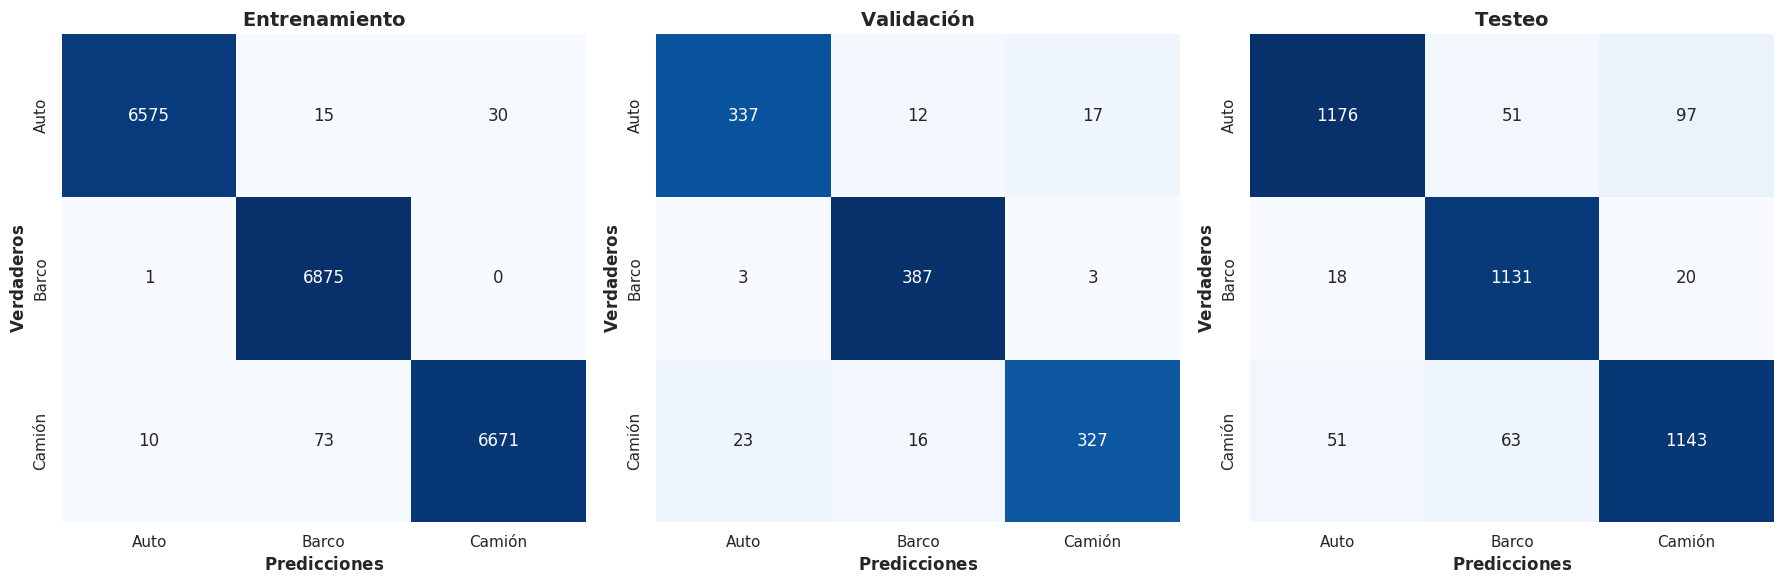

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nombres de las clases
class_names = ['Auto', 'Barco', 'Camión']

# Establecer un estilo personalizado
sns.set_theme(style="whitegrid", palette="pastel")

# Crear un gráfico con 1 fila y 3 columnas para mostrar las matrices de confusión
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Graficar las matrices de confusión en orientación horizontal sin la barra de colores
sns.heatmap(train_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axs[0])
axs[0].set_title(r'$\bf{Entrenamiento}$', fontsize=14)
axs[0].set_xlabel(r'$\bf{Predicciones}$', fontsize=12)
axs[0].set_ylabel(r'$\bf{Verdaderos}$', fontsize=12)

sns.heatmap(val_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axs[1])
axs[1].set_title(r'$\bf{Validación}$', fontsize=14)
axs[1].set_xlabel(r'$\bf{Predicciones}$', fontsize=12)
axs[1].set_ylabel(r'$\bf{Verdaderos}$', fontsize=12)

sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axs[2])
axs[2].set_title(r'$\bf{Testeo}$', fontsize=14)
axs[2].set_xlabel(r'$\bf{Predicciones}$', fontsize=12)
axs[2].set_ylabel(r'$\bf{Verdaderos}$', fontsize=12)

# Ajustar el diseño para evitar solapamiento de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [13]:
from prettytable import PrettyTable

# Definir un diccionario que mapea los índices a los nombres de las clases
class_to_idx = {"auto": 0, "barco": 1, "camión": 2}
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Encontrar las primeras predicciones incorrectas en el conjunto de prueba
incorrect_predictions = []
for i in range(len(test_true_labels)):
    if test_true_labels[i] != test_predictions[i]:
        incorrect_predictions.append(i)
    if len(incorrect_predictions) == 50: # Cantidad de primeras predicciones
        break

# Crear una tabla para mostrar los resultados incorrectos
table = PrettyTable(["Índice", "True Value", "True Class", "Predicted", "Predicted Class"])

# Llenar la tabla con las primeras 10 predicciones incorrectas
for i in incorrect_predictions:
    table.add_row([i, test_true_labels[i], idx_to_class[test_true_labels[i]],
                   test_predictions[i], idx_to_class[test_predictions[i]]])

# Imprimir la tabla de las primeras predicciones incorrectas para el conjunto de prueba
print("Predicciones Incorrectas para el Conjunto de Prueba:")
print(table)

Predicciones Incorrectas para el Conjunto de Prueba:
+--------+------------+------------+-----------+-----------------+
| Índice | True Value | True Class | Predicted | Predicted Class |
+--------+------------+------------+-----------+-----------------+
|   14   |     0      |    auto    |     1     |      barco      |
|   40   |     1      |   barco    |     2     |      camión     |
|   49   |     0      |    auto    |     1     |      barco      |
|   58   |     0      |    auto    |     2     |      camión     |
|   91   |     0      |    auto    |     2     |      camión     |
|  111   |     0      |    auto    |     1     |      barco      |
|  117   |     2      |   camión   |     0     |       auto      |
|  124   |     0      |    auto    |     2     |      camión     |
|  143   |     0      |    auto    |     2     |      camión     |
|  152   |     0      |    auto    |     1     |      barco      |
|  153   |     2      |   camión   |     1     |      barco      |
|  166   

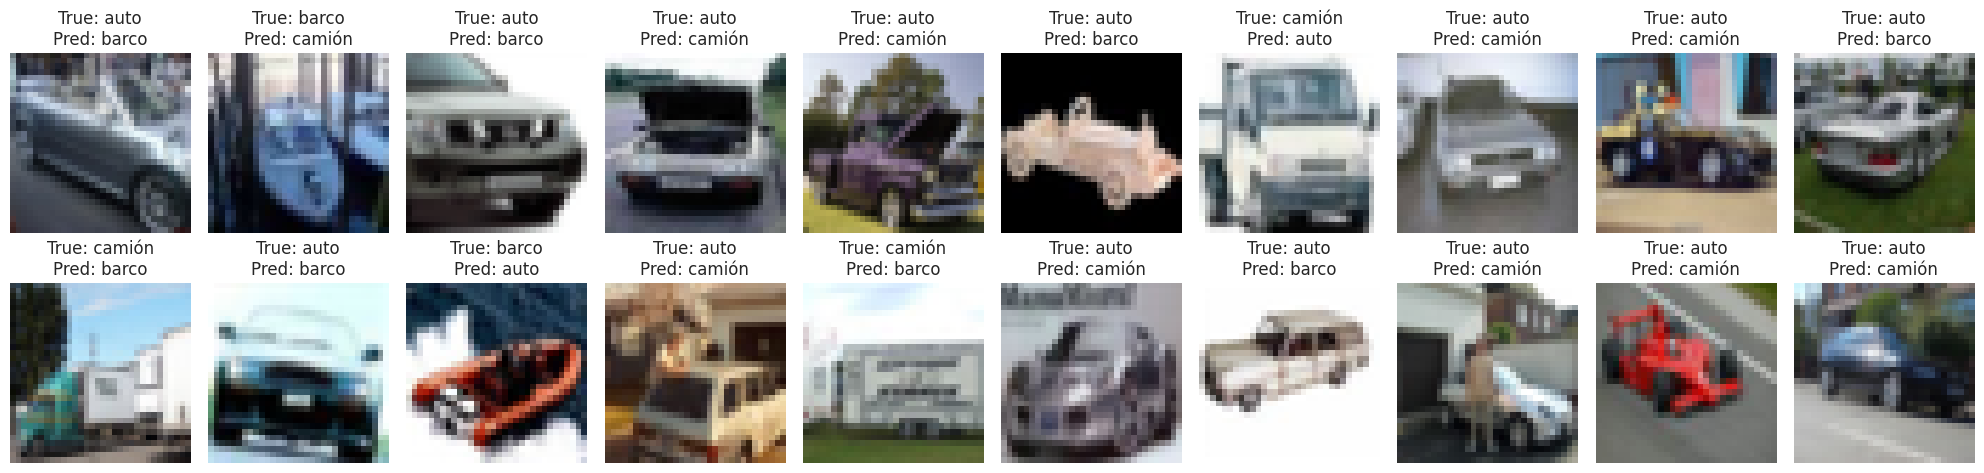

In [14]:
# Obtener las primeras 20 predicciones del conjunto definido arriba
incorrect_predictions = incorrect_predictions[:20]

# Crear una figura con dos filas y diez columnas
fig, axs = plt.subplots(2, 10, figsize=(20, 5))

# Iterar sobre las primeras 20 predicciones incorrectas
for i, ax in enumerate(axs.flat):
    # Obtener el índice de la predicción incorrecta
    incorrect_idx = incorrect_predictions[i]

    # Obtener la imagen, la clase real y la predicción
    img = test_data[incorrect_idx][0].permute(1, 2, 0).numpy()
    true_class = idx_to_class[test_true_labels[incorrect_idx]]
    predicted_class = idx_to_class[test_predictions[incorrect_idx]]

    # Mostrar la imagen
    ax.imshow(img)
    ax.set_title(f'True: {true_class}\nPred: {predicted_class}')
    ax.axis('off')

# Mostrar el resultado
plt.tight_layout()
plt.show()